## Streaming data visualisation
Plotting a line graph of air temperature against arrival time for incoming climate data.

In [1]:
# Libraries
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# Inline display
%matplotlib notebook

In [3]:
# Initialize topic name for Kafka broker
topic = "FIT3182_ASSIGNMENT_2"

In [4]:
# Function to annotate maximum value
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

In [5]:
# Function to annotate minimum value
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

In [6]:
# Function to initialize Kafka consumer
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

In [7]:
# Function to plot the streaming data graph initially
def init_plots():
    try:
        width = 10
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time Uniform Stream Data of Air Temperature against Arrival Time') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature (°C)')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.autofmt_xdate(rotation=45)
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    
    except Exception as ex:
        print(str(ex))

In [8]:
# Function to parse data from Kafka consumer and plot the streaming data
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8'))
            data = eval(data)
            
            if data['producer'] == '1':
                x.append(data['date_of_sending']) 
                y.append(int(data['air_temperature_celcius']))
            
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature (°C)')
                ax.set_ylim(0,40) 
                ax.set_yticks([0,10,20,30,40])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.autofmt_xdate(rotation=45)
                fig.show()
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
                
        plt.close('all')
        
    except Exception as ex:
        print(str(ex))

In [9]:
# Main Function to be called
def main():
    consumer = connect_kafka_consumer()
    fig,ax = init_plots()
    consume_messages(consumer,fig,ax)

<IPython.core.display.Javascript object>


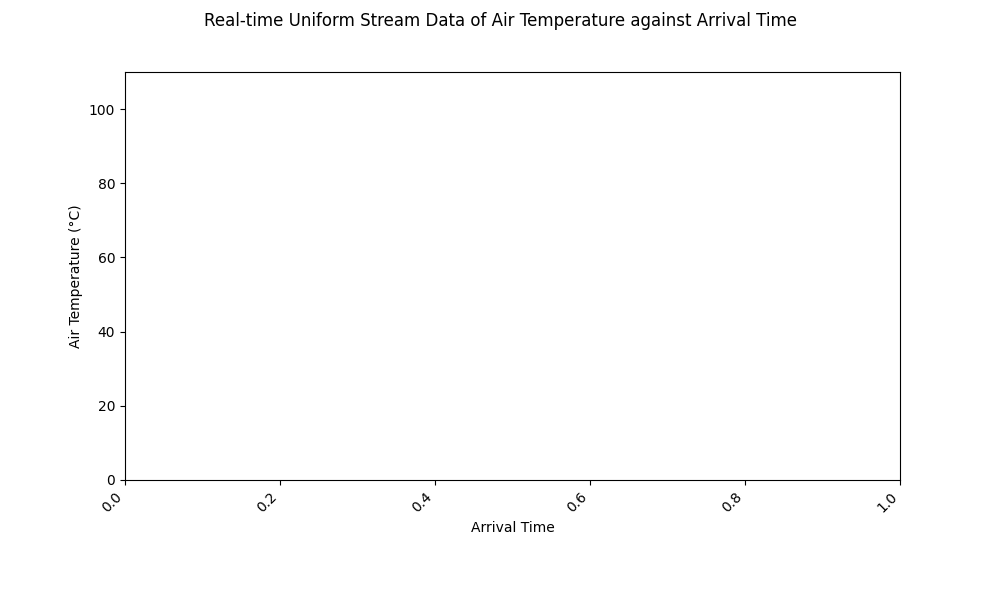

KeyboardInterrupt: 

In [10]:
if __name__ == '__main__':
    main()

## Static data visualisation

In [12]:
# Libraries
import pymongo
from pymongo import MongoClient
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
import folium

In [13]:
# Initialize MongoDB database
client = MongoClient()
db = client.fit3182_assignment_db
collection = db.data

### Bar chart of total number of fire records based on each hour

In [14]:
# Group data by hour
cursor = collection.aggregate([
    {
        '$unwind': '$hotspot'
    },
    {
        '$group': {
            '_id': '$hotspot.hour',
            'count':{'$sum':1}
        }
    }
])

# Initialize dictionary to store count based on hour
hour_dict = {}

# Place initial value
for i in range(0,24):
    hour_dict[i] = 0
    
# Insert aggregated value
for document in cursor:
    if document['_id'] is not None:
        hour_dict[document['_id']] = document['count']

<IPython.core.display.Javascript object>


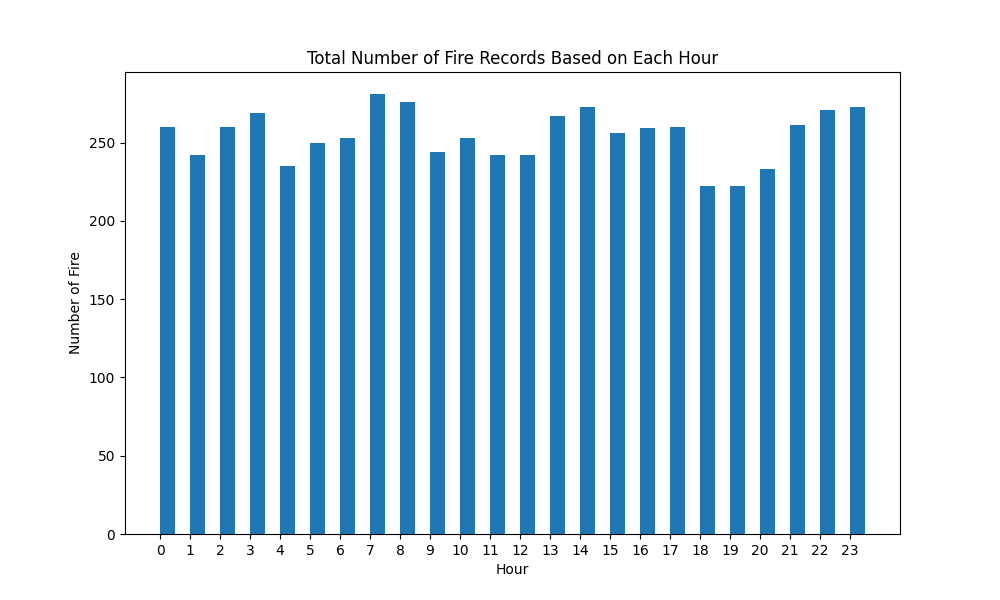

In [15]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.xticks(range(24), hour_dict)
plt.bar(range(24), hour_dict.values(), align='edge', width=0.5)

plt.xlabel('Hour')
plt.ylabel('Number of Fire')
plt.title('Total Number of Fire Records Based on Each Hour')
plt.show()

### Visualize fire locations in map

In [19]:
# Function to plot the map and the respective markers 
def plot_map(cursor):
    
    # Initialize map at Melbourne
    global_map = folium.Map(location=[-38.043995, 145.264296], zoom_start = 8)
        
    for document in cursor:
        hotspot = document['hotspot']
        
        # Obtain information
        lat = hotspot['latitude']
        long = hotspot['longitude']
        air_temp_cel = document['air_temperature_celcius']
        surf_temp_cel = hotspot['surface_temperature_celcius']
        humidity = document['relative_humidity']
        conf = hotspot['confidence']
        
        # Create message for popup box
        message = "Air Temperature (°C): {} <br> Surface Temperature (°C): {} <br> Relative Humidity: {} <br> Confidence: {}".format(
            air_temp_cel, surf_temp_cel, humidity, conf
        )
        iframe = folium.IFrame(message,width=250, height=85)
        popup = folium.Popup(iframe)
        
        # Adjust icon of marker based on cause of fire
        fire_icon = folium.Icon(color='red')
        if document['cause_of_fire'] == 'natural':
            fire_icon = folium.Icon(color='blue')
        
        # Add marker to the map
        folium.Marker([lat,long],popup=popup, icon=fire_icon).add_to(global_map)
        
    return global_map

In [27]:
# Plot the map
cursor = collection.aggregate([{'$unwind':'$hotspot'}])
global_map = plot_map(cursor)
display(global_map)